In [1]:
using Pkg; Pkg.activate("ToolsTechniques");

 Activating environment at `C:\Users\danny\git-repos\ToolsAndTechniques\ToolsTechniques\Project.toml`


In [2]:
Pkg.add(["DataFrames",
         "Images",
         "ImageMagick",
         "ImageBinarization",
         "MLJ",
         "Random",
         "StatsBase",
         "PrettyPrint",
         "CategoricalArrays",
         "Plots",
         "DecisionTree"]);

   Updating registry at `C:\Users\danny\.julia\registries\General`
   Updating git-repo `https://github.com/JuliaRegistries/General.git`


Fetching: [========================================>]  100.0 %.0 %

  Resolving package versions...
No Changes to `C:\Users\danny\git-repos\ToolsAndTechniques\ToolsTechniques\Project.toml`
No Changes to `C:\Users\danny\git-repos\ToolsAndTechniques\ToolsTechniques\Manifest.toml`


In [3]:
using DataFrames, Images, MLJ, Random, StatsBase, PrettyPrint, CategoricalArrays, Plots, ImageBinarization

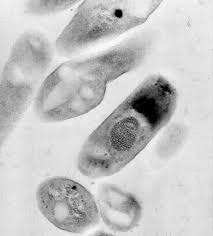

In [4]:
img1 = Images.load("binarize.jpg")

In [5]:
"""
    bernsen(img, rad, ij, contrast) -> neighborhood, pixel_val
Binarize (or threshhold) an image via local windows

# Arguments
    `img::Matrix{UInt8}`- The image to binarize
    `rad::Int`- The radius of the window
    `ij::CartesianIndex`- The row of the window's center pixel
    `contrast::UInt8`- The contrast level (Application-specific, default is 0x03)

# Returns
    `pix_val::UInt8`- 0x00 or 0xFF, which corresponds to whether the pixel is black or white

"""
function bernsen(img::Matrix{UInt8}, r::Int, ij::CartesianIndex{2}, c::UInt8=0x03)::Tuple{Vector,Bool}
    
    # Build an rxr neighborhood around (i,j)
    delta = CartesianIndices((-r:r, -r:r));
    nhood = img[ij .+ delta];
    # Get the minimum and maximum in that neighborhood
    Zmin,Zmax = extrema(nhood);
    # Make a local threshhold
    thresh = (Zmin+Zmax)/2;
    # If there is a large contrast
    if (Zmax - Zmin) >= c
        # Use the average of min and max as the threshhold
        return nhood[:], (img[ij] >= thresh);
    end
    # Otherwise, check if the average is high or low
    return nhood[:], (thresh >= 128);
end

bernsen

In [6]:
?bernsen

search: bernsen



```
bernsen(img, rad, ij, contrast) -> neighborhood, pixel_val
```

Binarize (or threshhold) an image via local windows

# Arguments

```
`img::Matrix{UInt8}`- The image to binarize
`rad::Int`- The radius of the window
`ij::CartesianIndex`- The row of the window's center pixel
`contrast::UInt8`- The contrast level (Application-specific, default is 0x03)
```

# Returns

```
`pix_val::UInt8`- 0x00 or 0xFF, which corresponds to whether the pixel is black or white
```


In [7]:
typeof(img1)

Array{Gray{Normed{UInt8,8}},2}

In [8]:
reinterpret(UInt8, img1)

236×213 reinterpret(UInt8, ::Array{Gray{N0f8},2}):
 0xf0  0xf0  0xf0  0xf0  0xf1  0xf1  …  0xeb  0xe2  0xe3  0xe5  0xe7  0xe8
 0xef  0xef  0xf0  0xf0  0xf1  0xf1     0xe9  0xe3  0xe4  0xe5  0xe7  0xe8
 0xef  0xef  0xef  0xef  0xf0  0xf0     0xe7  0xe5  0xe6  0xe7  0xe7  0xe8
 0xee  0xee  0xee  0xef  0xef  0xef     0xe9  0xe7  0xe8  0xe8  0xe8  0xe8
 0xed  0xed  0xed  0xee  0xee  0xee     0xeb  0xea  0xea  0xe9  0xe9  0xe9
 0xec  0xec  0xec  0xed  0xed  0xed  …  0xeb  0xec  0xec  0xeb  0xea  0xe9
 0xeb  0xeb  0xec  0xec  0xec  0xed     0xe7  0xee  0xed  0xec  0xea  0xe9
 0xeb  0xeb  0xeb  0xec  0xec  0xec     0xe2  0xef  0xee  0xec  0xeb  0xea
 0xed  0xed  0xed  0xed  0xed  0xed     0xeb  0xea  0xea  0xe9  0xe9  0xe8
 0xed  0xed  0xed  0xed  0xed  0xed     0xeb  0xea  0xea  0xe9  0xe9  0xe8
 0xec  0xec  0xec  0xec  0xec  0xec  …  0xea  0xea  0xea  0xe9  0xe9  0xe8
 0xeb  0xeb  0xeb  0xeb  0xeb  0xeb     0xea  0xea  0xea  0xe9  0xe9  0xe8
 0xea  0xea  0xea  0xea  0xea  0xea     0xe9  0xe

In [9]:
function apply_bernsen(img::Matrix{UInt8}, r::Int, c::UInt8=0x02)
    idxs = CartesianIndices(img[r+1:end-r, r+1:end-r]);
    idxs_sz = size(idxs);
    result = Matrix(undef, idxs_sz[1], idxs_sz[2]);
    
    for ij in idxs
        result[ij] = bernsen(img, r, ij + CartesianIndex(r,r), c);
    end
    
    features = hcat([x[1] for x in result[:]]...)';
    img_bin = [x[2] for x in result];
    labels = img_bin[:];
    return features, labels, Matrix{Gray{Bool}}(img_bin);
end

apply_bernsen (generic function with 2 methods)

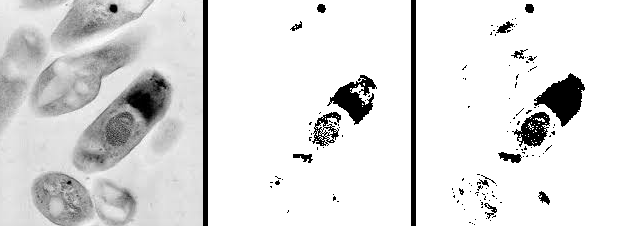

In [10]:
img1_array = Matrix{UInt8}(reinterpret(UInt8, img1));
# Set radius equal to 5
rad = 5;

img1_old = img1[rad+1:end-rad, rad+1:end-rad];
img1_feat, img1_lab, img1_new = apply_bernsen(img1_array, rad);
border = zeros(Gray{Bool},(size(img1_old,1),5));
hcat(img1_old, border, img1_new, border, binarize(img1_old, Yen()))

In [11]:
white_idxs = findall(img1_lab);
black_idxs = setdiff(1:length(img1_lab), white_idxs);
n_resample = 10000;
white_resample = sample(white_idxs, n_resample);
black_resample = sample(black_idxs, n_resample);
img1_lab_resample = vcat(img1_lab[black_resample], img1_lab[white_resample]);
img1_feat_resample = vcat(img1_feat[black_resample,:], img1_feat[white_resample,:]);

perm_rows = shuffle(1:2*n_resample);
img1_feat_resample = img1_feat_resample[perm_rows,:];
img1_lab_resample = img1_lab_resample[perm_rows];

In [12]:
sum(img1_lab[white_resample])

10000

In [13]:
xgb = @load XGBoostClassifier;

In [14]:
F = 5; prop_train=0.8;
img1_feat_retype = DataFrame(coerce(img1_feat, autotype(img1_feat, :discrete_to_continuous)));
img1_lab_retype = coerce(img1_lab, autotype(img1_lab, :few_to_finite));

r = range(xgb, :num_round, lower=1, upper=50);
tm = TunedModel(model=xgb, tuning=Grid(resolution=8),
                resampling=CV(nfolds=5), ranges=r,
                measure=area_under_curve);
m = machine(tm, img1_feat_retype, img1_lab_retype);
fit!(m);
rep = report(m);
rep

┌ Info: Training Machine{ProbabilisticTunedModel{Grid,…}} @ 1…67.
└ @ MLJBase C:\Users\danny\.julia\packages\MLJBase\8HOpr\src\machines.jl:187
┌ Info: Attempting to evaluate 8 models.
└ @ MLJTuning C:\Users\danny\.julia\packages\MLJTuning\JZ7ZX\src\tuned_models.jl:501
Evaluating over 8 metamodels: 100%[=========================] Time: 0:02:06


(best_model = XGBoostClassifier @ 7…00,
 best_result = (measure = [area_under_curve],
                measurement = [NaN],),
 best_report = (feature_importances = 121-element Vector{XGBoost.FeatureImportance}:
Gain      Coverage  Frequency  Feature
0.8139    0.8277    0.1375     x61
0.0149    0.0068    0.0169     x11
0.0056    0.0029    0.0147     x12
0.0048    0.0061    0.0158     x110
0.0043    0.0009    0.0090     x46
0.0042    0.0025    0.0101     x7
0.0039    0.0025    0.0113     x88
0.0035    0.0024    0.0090     x116
0.0034    0.0027    0.0090     x21
0.0033    0.0047    0.0147     x77
0.0029    0.0018    0.0090     x4
0.0029    0.0037    0.0158     x121
0.0028    0.0021    0.0101     x24
0.0027    0.0024    0.0158     x40
0.0026    0.0019    0.0068     x8
0.0025    0.0031    0.0101     x6
0.0025    0.0016    0.0113     x119
0.0025    0.0015    0.0079     x98
0.0024    0.0013    0.0147     x2
0.0023    0.0017    0.0101     x120
0.0023    0.0023    0.0068     x33
0.0022    0.0018

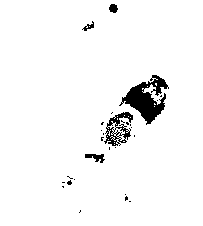

In [15]:
prediction = MLJ.predict(m, Matrix(img1_feat));
outcome = reshape([argmax(p.prob_given_ref.vals) == 2 for p in prediction], size(img1_old));
Matrix{Gray{Bool}}(outcome)

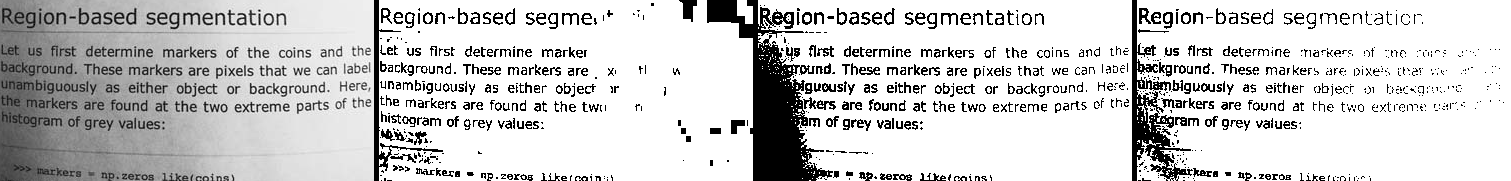

In [16]:
img2 = Images.load("binarize2.jpg");
img2_array = Matrix{UInt8}(reinterpret(UInt8, img2));

# Set radius equal to 5
rad = 5;

img2_old = img2[rad+1:end-rad, rad+1:end-rad];
img2_feat, img2_lab, img2_new = apply_bernsen(img2_array, rad);
img2_feat_retype = DataFrame(coerce(img2_feat, autotype(img2_feat, :discrete_to_continuous)));
border = zeros(Gray{Bool},(size(img2_old,1),5));
img2_pred = MLJ.predict(m, Matrix(img2_feat));
img2_xgb = reshape([argmax(p.prob_given_ref.vals) == 2 for p in img2_pred], size(img2_old));
hcat(img2_old, border, img2_new, border, binarize(img2_old, Yen()), border, Gray.(img2_xgb))